# Problem Statement

There is a large opportunity to generate revenue for Organization by having sales agents proactively engage customers shopping our site. To identify potential customers, we have a data science model that uses various internal and external signals from user browsing behavior to generate leads for our sales team to reach out on. 

The tenets for driving outbound program is:
- Increase revenue that is incremental to Organization
- Maintain positive variable contribution margin (VCD)

We need to advise the business what type of leads are best to pursue

# Assumptions

- We considered the Lead Activity based on the Lead Generation Date for calculating Revenue earned for the respective Lead. Only Activity greater than or equal to the lead generation date has been taken into account.


- In order to arrive at a conclusion, we calculate the average revenue earned because of the agent activities (the called/testing slice) against the 45 Day Expected Revenue of the Control group. If the generated revenue is more or close to 45 Day Expected Revenue of Control Group, we can conclude that keeping the customers engaging has helped Wayfair for that Lead Type


- Incrementality/VCD has been calculated as below:

    Incrementality = (Avg Called Revenue Generated - Avg Exp 45 Day Revenue of Control group)/ (Avg Called Revenue Generated)
    
    VCD = (Total Called Revenue Generated - Total Control Expected 45 Day Revenue) - Total Called Cost



# Data and Package Loading 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta

Lead Table and Agent Data are 2 Datasources that are imported and is used for analysis and generating recommendations

In [1]:
agent_activity_df = pd.read_excel('/Users/sagarsahoo/Desktop/Wayfair_Case_Study/input/Agent_Activity_Table.xlsx')
lead_table_df = pd.read_excel('/Users/sagarsahoo/Desktop/Wayfair_Case_Study/input/Lead_Table.xlsx')

NameError: name 'pd' is not defined

# Data Description

The Lead Table contains the Lead IDs, Date of Lead Generation, Lead Type/Slice and expected 45 Day Revenue.

And the Agent Activity Table contains the activity history(Call Time, Order ID and Revenue) for the respective Lead IDs

In [3]:
lead_table_df.head(3)

,LeadID,LeadCreationDate,LeadType,LeadScore,Lead Slice,45dayRev,LeadOwnerEmpId
0,680376,2018-12-20 22:11:35.000,Customer- 2nd Home,44,1,0.0,1
1,200758,2018-11-20 09:05:57.261,Customer- New Home,2,1,0.0,1
2,285305,2019-03-01 04:58:03.097,Out of Stock,95,1,0.0,1


In [4]:
agent_activity_df.head(3)

,EmpID,LeadIDCalled,CallStartTime,CallEndTime,OrderID,Revenue
0,1207,393533,2018-12-31 19:51:12.000,2018-12-31 20:00:27.000,30481774.0,113.49
1,976,806783,2019-02-25 10:27:06.495,2019-02-25 10:34:34.695,0.0,0.00
2,543,120666,2018-11-19 12:35:21.445,2018-11-19 12:38:21.445,0.0,0.00


In [5]:
print("The Shape of Leads Data Source  is: ", lead_table_df.shape)
print("The Shape of Leads Activity  Data Source is: ", agent_activity_df.shape)

The Shape of Leads Data Source  is:  (9974, 7)
The Shape of Leads Activity  Data Source is:  (50000, 6)


# Analysis

In order to understand the spread, we check the average expected 45 Day Revenue across the Lead Types

In [6]:
describe_df = lead_table_df.groupby(['LeadType','Lead Slice'],as_index=False).agg({'45dayRev':['count','mean','median']})
describe_df.columns = ['LeadType', 'Lead Slice','Total_Leads','Avg_45dayRev','Median_45dayRev']

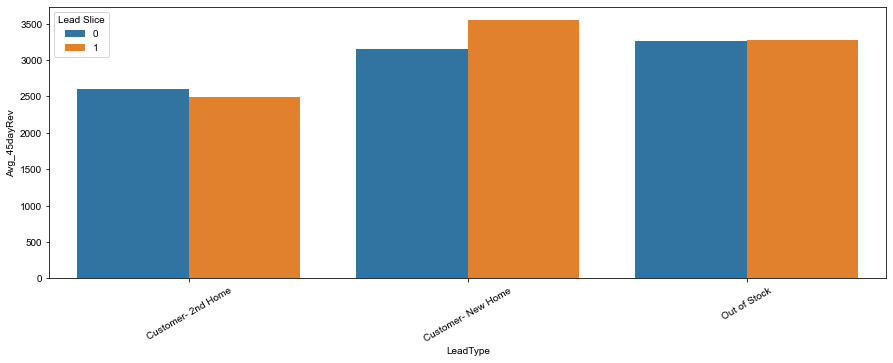

In [7]:
plt.figure(figsize=(15,5))
bar =  sns.barplot(x=describe_df.LeadType, y=describe_df.Avg_45dayRev,hue=describe_df['Lead Slice'])
bar.set_xticklabels(bar.get_xticklabels(), rotation=30)
sns.set_style("whitegrid", {'grid' : False})


For <b>Customer- 2nd Home</b>, the average 45 Day Expected revenue is the <b>Least</b> for the Variation/Test slice as compared to New Home and Out of Stock Lead Type

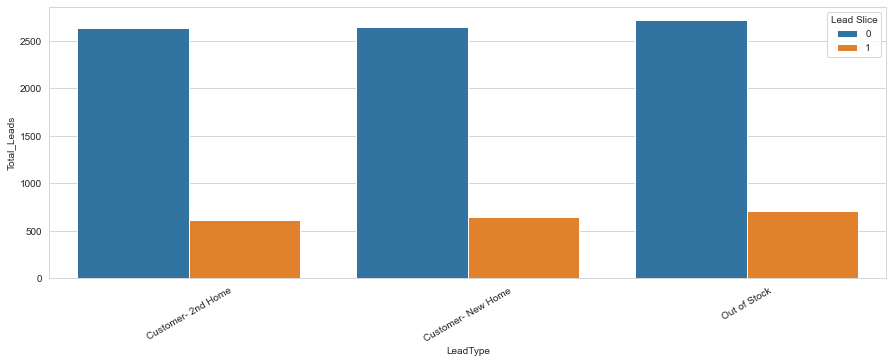

In [8]:
plt.figure(figsize=(15,5))
bar =  sns.barplot(x=describe_df.LeadType, y=describe_df.Total_Leads,hue=describe_df['Lead Slice'])
bar.set_xticklabels(bar.get_xticklabels(), rotation=30)
sns.set_style("white", {'grid' : False})

The distribution of the Testing and Control Groups has been consistent across the Lead Types

Now, we merge the data sources to proceed with analysis of leads. On merging, the activities without the Lead IDs will be skipped as those cannot be mapped to the Leads Table

In [9]:
leads_merged_df = lead_table_df.merge(agent_activity_df,how='left',left_on='LeadID', right_on='LeadIDCalled')

In [10]:
print("The Shape of Merged Data Source  is: ", leads_merged_df.shape)

The Shape of Merged Data Source  is:  (27371, 13)


In [11]:
leads_merged_df.head(2)

,LeadID,LeadCreationDate,LeadType,LeadScore,Lead Slice,45dayRev,LeadOwnerEmpId,EmpID,LeadIDCalled,CallStartTime,CallEndTime,OrderID,Revenue
0,680376,2018-12-20 22:11:35.000,Customer- 2nd Home,44,1,0.0,1,NaN,NaN,NaT,NaT,NaN,NaN
1,200758,2018-11-20 09:05:57.261,Customer- New Home,2,1,0.0,1,NaN,NaN,NaT,NaT,NaN,NaN


As per our assumptions since, the leads are generated on a given date, we only consider the activity history (CallStartTime) <b>greater than and equal to </b>the Lead Created Date (LeadCreationDate)

In [12]:
leads_merged_df = leads_merged_df[leads_merged_df['CallStartTime']>=leads_merged_df['LeadCreationDate']]

In [13]:
print("The Shape of Merged Data Source  is now : ", leads_merged_df.shape)

The Shape of Merged Data Source  is now :  (12524, 13)


In [14]:
leads_merged_df.head(2)

,LeadID,LeadCreationDate,LeadType,LeadScore,Lead Slice,45dayRev,LeadOwnerEmpId,EmpID,LeadIDCalled,CallStartTime,CallEndTime,OrderID,Revenue
2312,997865,2019-01-10 00:08:12.478,Out of Stock,52,0,1889.17,951,951.0,997865.0,2019-03-02 11:19:10.292,2019-03-02 11:22:06.692,46619891.0,578.78
2315,811632,2018-12-31 19:04:00.142,Customer- New Home,69,0,1789.06,796,796.0,811632.0,2019-02-01 13:36:29.899,2019-02-01 13:39:34.099,60001936.0,1789.06


We see that we loose out chunk of the activity history<b> (~ 15K )</b> of the agents when we constrained the activity to greater than or equal to lead generation date

In order to see, if the final conclusion depends on this assumption or not, we will remove this constraint and check the conclusion in the future.

Now, In order to have an estimate of the time spent by Agent on each call (in seconds), we calculate the difference of Call End Time and Call Start Time

In [15]:
leads_merged_df['call_time_ss']=(leads_merged_df.CallEndTime-
                                 leads_merged_df.CallStartTime).astype('timedelta64[s]')

Since, the merged data is not aggregated at Leads level, we aggregate the data and calculate sum of call time and revenue respectively.

In [16]:
analysis_temp_df = leads_merged_df.groupby(['LeadID','LeadType','Lead Slice','45dayRev','LeadCreationDate'],as_index=False).agg({'call_time_ss':'sum','Revenue':'sum'})
analysis_temp_df.head(5)

,LeadID,LeadType,Lead Slice,45dayRev,LeadCreationDate,call_time_ss,Revenue
0,100622,Out of Stock,0,6206.65,2019-01-27 09:52:47.748,33.0,579.02
1,100639,Customer- New Home,0,1177.70,2019-02-03 15:10:59.672,336.0,167.74
2,100656,Out of Stock,0,11743.42,2018-12-16 06:31:19.793,1032.0,0.00
3,100659,Customer- 2nd Home,0,0.00,2019-01-02 02:18:42.584,805.0,0.00
4,101195,Customer- New Home,0,0.00,2019-03-12 23:27:40.599,274.0,0.00


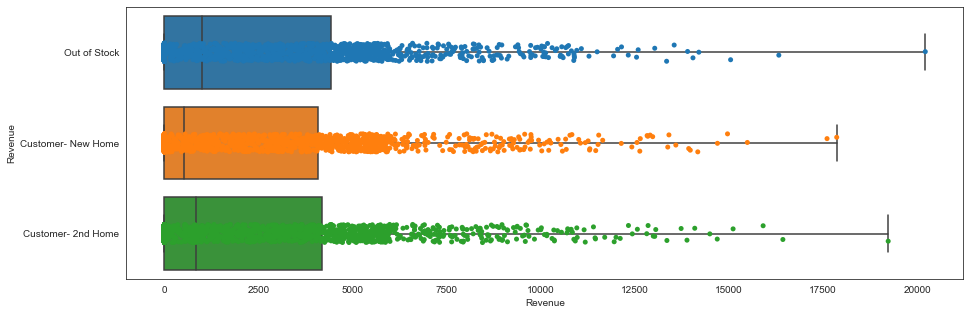

In [17]:
plt.figure(figsize=(15, 5))
ax = sns.stripplot(y="LeadType", x="Revenue", jitter = True, data=analysis_temp_df)
ax = sns.boxplot(y="LeadType", x="Revenue", data=analysis_temp_df, whis=np.inf)
ax.set_ylabel('Revenue', fontsize = 10)
sns.set_style("whitegrid", {'grid' : False})

The above box plot integrated with strip plot shows the density with the median values of the revenue across the leads for the 3 lead types. 

In [18]:
analysis_df = analysis_temp_df.groupby(['LeadType','Lead Slice'],as_index=False).agg({'LeadID':'count',
                                                                '45dayRev':'sum','Revenue':'sum',
                                                                'call_time_ss':'sum'})

analysis_df.rename(columns={'LeadID': 'Total_Leads', '45dayRev': 'Total_45dayRev','Revenue':'Total_Revenue','call_time_ss':'Total_Call_Time'}, inplace=True)

analysis_df['Total_Call_Cost'] = analysis_df['Total_Call_Time'] * (25/3600)
analysis_df['Avg_45dayRev'] = analysis_df['Total_45dayRev']/analysis_df['Total_Leads']
analysis_df['Avg_Revenue'] = analysis_df['Total_Revenue']/analysis_df['Total_Leads']
analysis_df['Avg_Call_Cost'] = analysis_df['Total_Call_Cost']/analysis_df['Total_Leads']
analysis_df

,LeadType,Lead Slice,Total_Leads,Total_45dayRev,Total_Revenue,Total_Call_Time,Total_Call_Cost,Avg_45dayRev,Avg_Revenue,Avg_Call_Cost
0,Customer- 2nd Home,0,1833,5243641.248,4234475.39,1246988.0,8659.638889,2860.688079,2310.133873,4.724298
1,Customer- New Home,0,1831,6292008.580,4048415.64,1216034.0,8444.680556,3436.378252,2211.040765,4.612059
2,Out of Stock,0,1905,6918285.120,4487107.01,1303579.0,9052.631944,3631.645732,2355.436751,4.752038


In [19]:
analysis_control_df = lead_table_df[lead_table_df['Lead Slice']==1].groupby(['LeadType','Lead Slice'],as_index=False).agg({'45dayRev':['count','mean']})
analysis_control_df.columns = ['LeadType', 'Control Lead Slice','Total_Control_Leads','Avg_Control_45dayRev']
analysis_control_df

,LeadType,Control Lead Slice,Total_Control_Leads,Avg_Control_45dayRev
0,Customer- 2nd Home,1,612,2492.851634
1,Customer- New Home,1,650,3554.988308
2,Out of Stock,1,712,3269.597157


In [20]:
summary_df = analysis_df[['LeadType','Total_Leads','Avg_45dayRev','Avg_Revenue','Avg_Call_Cost']].merge(analysis_control_df,how='inner',left_on='LeadType', right_on='LeadType')
summary_df.rename(columns={'Total_Leads': 'Total_Test_Leads', 'Avg_45dayRev': 'Avg_Test_45dayRev'}, inplace=True)
summary_df

,LeadType,Total_Test_Leads,Avg_Test_45dayRev,Avg_Revenue,Avg_Call_Cost,Control Lead Slice,Total_Control_Leads,Avg_Control_45dayRev
0,Customer- 2nd Home,1833,2860.688079,2310.133873,4.724298,1,612,2492.851634
1,Customer- New Home,1831,3436.378252,2211.040765,4.612059,1,650,3554.988308
2,Out of Stock,1905,3631.645732,2355.436751,4.752038,1,712,3269.597157


We see that for the Lead Type "Customer- 2nd Home" the difference in Average 45 Day Revenue of Control group is not significantly different from the called generated revenue. 

However, for "Customer- New Home" and "Out of Stock", there is significant difference betwen the Average 45 Day Revenue of Control Group against the Called Generated Revenue

Now, we frame hypothesis around the samples and use Hypothesis Testing to confirm if the difference is significant or not

In [23]:
from scipy import stats

contrl_2ndhome_df = lead_table_df[(lead_table_df['LeadType']=='Customer- 2nd Home') & (lead_table_df['Lead Slice'] == 1) ]['45dayRev']
var_2ndhome_df = analysis_temp_df[((analysis_temp_df['LeadType']=='Customer- 2nd Home') & (analysis_temp_df['Lead Slice'] == 0) )]['Revenue']

print("Test for Significance in Difference of Means across Control/Test Groups for Customer- 2nd Home : ")
print("\n")
print(stats.ttest_ind(contrl_2ndhome_df, var_2ndhome_df, equal_var = False))

Test for Significance in Difference of Means across Control/Test Groups for Customer- 2nd Home : 


Ttest_indResult(statistic=0.6542987758547435, pvalue=0.5131364200923476)


We see that there is <b>No Significant Difference </b> between 45 day revenue per lead between called and controlled slice as p-value > 0.05 (Assuming 5% Level of Significance)

So we can rely on the leads suggested by the Data Science Team for <b>Customer - 2nd Home</b> Lead Type

In [24]:
contrl_newhome_df = lead_table_df[(lead_table_df['LeadType']=='Customer- New Home') & (lead_table_df['Lead Slice'] == 1) ]['45dayRev']
var_newhome_df = analysis_temp_df[((analysis_temp_df['LeadType']=='Customer- New Home') & (analysis_temp_df['Lead Slice'] == 0) )]['Revenue']

print("Test for Significance in Difference of Means across Control/Test Groups for Customer- New Home : ")
print(stats.ttest_ind(contrl_newhome_df, var_newhome_df, equal_var = False))


contrl_outofstock_df = lead_table_df[(lead_table_df['LeadType']=='Out of Stock') & (lead_table_df['Lead Slice'] == 1) ]['45dayRev']
var_outofstock_df = analysis_temp_df[((analysis_temp_df['LeadType']=='Out of Stock') & (analysis_temp_df['Lead Slice'] == 0) )]['Revenue']

print("\n")
print("Test for Significance in Difference of Means across Control/Test Groups for Out of Stock : ")
print(stats.ttest_ind(contrl_outofstock_df, var_outofstock_df, equal_var = False))

Test for Significance in Difference of Means across Control/Test Groups for Customer- New Home : 
Ttest_indResult(statistic=2.952490733947311, pvalue=0.0032608946359735384)


Test for Significance in Difference of Means across Control/Test Groups for Out of Stock : 
Ttest_indResult(statistic=2.5880465400358905, pvalue=0.0098356121068178)


We see that there is <b>Significant Difference </b> between 45 day revenue per lead between called and
controlled slice as p-value < 0.05 and we reject our Null Hypothesis - "45 Day Expected Revenue is equal to Called Revenue Generated" (Assuming 5% Level of Significance) both for <b> Customer- New Home and Out of Stock </b>Leads


Tenets for driving outbound program:

We consider positive incrementality % and Variable Contribution Margin (VCD) as the criteria to drive the outbound program. 

In [25]:
summary_df['Incrementality'] = (summary_df['Avg_Revenue'] - summary_df['Avg_Control_45dayRev'])*100/summary_df['Avg_Control_45dayRev']
summary_df['VCD'] = summary_df['Avg_Revenue']*summary_df['Total_Test_Leads']-summary_df['Avg_Control_45dayRev']*summary_df['Total_Control_Leads']-summary_df['Avg_Call_Cost']*summary_df['Total_Test_Leads']

In [26]:
pd.options.display.float_format = '{:.5f}'.format 
summary_df

,LeadType,Total_Test_Leads,Avg_Test_45dayRev,Avg_Revenue,Avg_Call_Cost,Control Lead Slice,Total_Control_Leads,Avg_Control_45dayRev,Incrementality,VCD
0,Customer- 2nd Home,1833,2860.68808,2310.13387,4.72430,1,612,2492.85163,-7.32967,2700190.55111
1,Customer- New Home,1831,3436.37825,2211.04076,4.61206,1,650,3554.98831,-37.80456,1729228.55944
2,Out of Stock,1905,3631.64573,2355.43675,4.75204,1,712,3269.59716,-27.95942,2150101.20206


In [27]:
summary_df.to_csv('summary.csv')

So, from the above table we see that the Average 45 Day Revenue for the <b>Customer- 2nd Home </b>Control Group is slightly more than Average Called Revenue. Hence the Incrementality is on the negative side. The VCD being <b>2700190.55111</b>. This is better as compared to the other Lead Types - New Home and Out of Stock.

From Hypothesis Testing, we proved that the difference in 45 Day Revenue between Called and Control Group for Customer- 2nd Home is  <b>not significant </b>. However the difference is <b>significant </b>for the other lead types and which is consistent with the figures shown as well.

So far, the analysis is based on the assumption of <b>using lead activities after the respective lead generation date </b>. If we try ignoring this assumption and consider the revenue earned irrespective of the lead generation date, we will end with positive incrementality % and positivie VCD for <b>Customer- 2nd Home </b>, thereby assuring us that calling leads help us keep the leads engaging and bring in more revenue

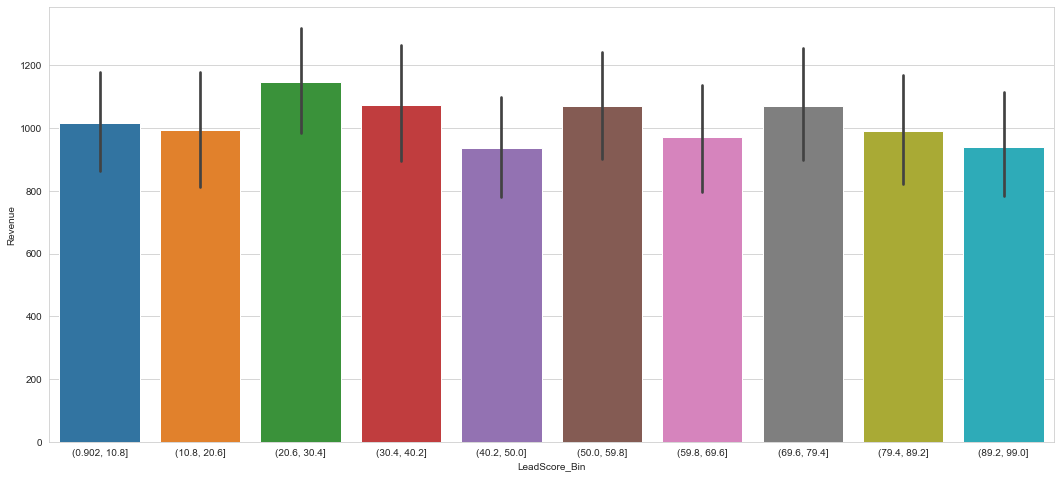

In [28]:
leads_merged_binned_df = leads_merged_df[(leads_merged_df['LeadType']=='Customer- 2nd Home') & 
                (leads_merged_df['Lead Slice']==0)]
leads_merged_binned_df['LeadScore_Bin'] = pd.cut(leads_merged_df[(leads_merged_df['LeadType']=='Customer- 2nd Home') & 
                (leads_merged_df['Lead Slice']==0)]['LeadScore'], bins=10)
leads_binned_analysis_df = leads_merged_binned_df.groupby(['LeadScore_Bin'],as_index=False).agg({'Revenue':'mean','call_time_ss':'mean'})
plt.figure(figsize=(18,8))
sns.barplot(x="LeadScore_Bin",y="Revenue",data=leads_merged_binned_df)
sns.set_style("whitegrid")

For Second Customer Home Leads, we see that the average revenue for Lead Score Bins 20-30 is highest. And the average  revenue for bins 30-40, 50-60 and 70-80 are higher as compared to the others.

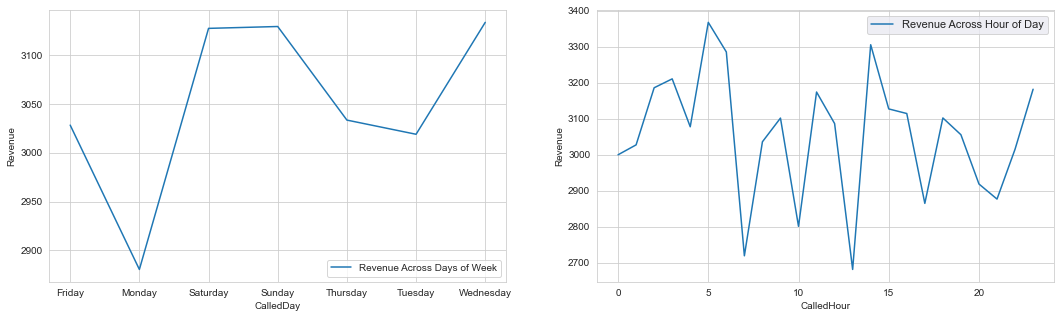

In [29]:
success_df = leads_merged_df[(leads_merged_df['LeadType']=='Customer- 2nd Home') & 
                (leads_merged_df['Lead Slice']==0) & (leads_merged_df['OrderID'] !=0)]
success_df['CalledDay'] = success_df['CallStartTime'].dt.day_name()
success_df['CalledHour'] = success_df['CallStartTime'].dt.hour

fig, ax =plt.subplots(1,2,figsize=(18,5))

day_temp_df = success_df.groupby(['CalledDay'],as_index=False).agg({'Revenue':'mean'})
sns.lineplot(x="CalledDay", y="Revenue", data=day_temp_df, ax=ax[0],label="Revenue Across Days of Week")

hr_temp_df = success_df.groupby(['CalledHour'],as_index=False).agg({'Revenue':'mean'})
import seaborn as sns; sns.set()
sns.lineplot(x="CalledHour", y="Revenue", data=hr_temp_df, ax=ax[1],label="Revenue Across Hour of Day")
plt.show()

sns.set_style("dark", {'grid' : False})

In [47]:
lead_conv_df = leads_merged_df[(leads_merged_df['Lead Slice']==0)].groupby(['LeadType','LeadID'],as_index=False).agg({'OrderID':lambda x: x[x != 0.00000].count(),'Revenue':'sum','CallStartTime':'count'})
conversion_summary_df = lead_conv_df.groupby(['LeadType'],as_index=False).agg({'LeadID':'count','CallStartTime':'mean','OrderID':lambda x: x[x == 0.00000].count()})
conversion_summary_df.rename(columns={'LeadID': 'NoofLeadIDs', 'CallStartTime': 'Avg No of Calls','OrderID':'#Leads Without Order'}, inplace=True)
conversion_summary_df['Conversion%'] = (conversion_summary_df['NoofLeadIDs']-conversion_summary_df['#Leads Without Order'])*100/conversion_summary_df['NoofLeadIDs']
conversion_summary_df

,LeadType,NoofLeadIDs,Avg No of Calls,#Leads Without Order,Conversion%
0,Customer- 2nd Home,1833,2.26132,804.00000,56.13748
1,Customer- New Home,1831,2.23484,847.00000,53.74113
2,Out of Stock,1905,2.25039,829.00000,56.48294


So we are seeing <b>56%</b> Conversion ratio for the Customer- 2nd Home Lead Type which is as well closely similar with the other lead types

Here, we see that for Lead Type "Customer- 2nd Home", Agents were able to generate maximum revenue on <b>Saturday, Sunday and Wednesday </b>of the week. And the best time to approach the customers is at <b>5 AM and 14 PM</b> respectively. 

In [30]:
agent_performance_df = success_df.groupby(['LeadOwnerEmpId'],as_index=False).agg({'LeadID':lambda x: x.nunique(),'Revenue':'sum','CallStartTime':'count'})
agent_performance_df.rename(columns={'LeadID': 'NoofLeadIDs', 'Revenue': 'Total_Revenue','CallStartTime':'NoofCalls'}, inplace=True)
agent_performance_df['Avg_Revenue_per_Lead'] = agent_performance_df['Total_Revenue']/agent_performance_df['NoofLeadIDs']
agent_performance_df.sort_values(by='Avg_Revenue_per_Lead',ascending=False).head(5)

,LeadOwnerEmpId,NoofLeadIDs,Total_Revenue,NoofCalls,Avg_Revenue_per_Lead
10,976,32,151677.01000,45,4739.90656
0,81,43,195852.59000,57,4554.71140
23,1465,41,181717.95000,60,4432.14512
9,951,54,237903.18000,75,4405.61444
2,301,36,158575.33000,48,4404.87028


We see the average revenue generated for the top 5 Agents are above $4404 per Lead.

# Recommendations

- Concerning our business case, we analyzed the testing revenue against the controlled revenue for the 3 Lead Types. Under the assumption "Only Activity greater than or equal to the lead generation date should be considered to understand the impact of calling leads", we found it keeping the customer engaging for <b>Customer - 2nd Home</b> can be profitable as compared to New Home and Out of Stock. Using Hypothesis testing we proved that the difference isn't significant between the control and called group. Although the incrementality is -7.3%, we can conclude that the expected revenue of the control group was close to the called revenue generated. The VCD was positive for the lead type as well.


- We tried ignoring the assumptions and aggregated the revenue generated through the leads and on comparing the average called revenue with 45 Day Expected Revenue of the Control group, and found that the Lead Type - <b>Customer - 2nd Home</b> is profitable. This is in line with our results under the said assumption.



- We also found the below key insghts for leads of the Type - "Customer - 2nd Home": 

        - Reaching out on Saturday, Sunday and Wednesday has higher chance of a conversion
        - 5 AM and 2 PM are the ideal times to reach out
        - Leads with Score (20-30) can be given higher preference followed by 40-50,50-60 and 70-80. 
        - The "Average Revenue per Lead" isnt varying much across the Agents. 
        - We can expect conversion rate of ~56% if we are reaching twice to leads on average